# 0. Remarks of the author

1. This code works as a skeleton, so that users can exploit it and define their own implementations. This means that the users should **NOT** expect to run this code solely to get the figures of the publication. 

2. To specify the utility and cost functions, the users that are interested have 3 options:
    1. define their own functions/emulators, 
    2. use our (limited) dataset https://github.com/jaayala/power_dlul_dataset,
    3. send email to m.kalntis@tudelft.nl to ask more information.

3. If you use any piece of the code, please check *README.md* for citing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# we set a seed to get same random numbers each time we run the experiment
np.random.seed(5)

# 1. Functions to emulate testbed

We define the weight parameter `delta`, which prioritizes the maximization of utility or the minimization of the power costs.

In [2]:
delta = 1

## 1.1 Utility function

In [3]:
def fun_utility(s_t, cd_t):
    ''' 
    Description
    -----------
    - This is a dummy utility function.
    - Check section 0 (Remarks of the author, above) for more information.
    -----------

    Parameters
    ----------
    ----------
    '''
    dummy_val = sum(list(s_t))*np.random.random() + sum(list(cd_t))*np.random.random()
    return dummy_val

## 1.2 Power cost function

In [4]:
def fun_power(s_t, cd_t):
    '''
    Description
    -----------
    - This is a dummy power cost function.
    - Check section 0 (Remarks of the author, above) for more information.
    -----------
    
    Parameters
    ----------
    ----------
    '''
    dummy_val = sum(list(s_t))*np.random.random() + sum(list(cd_t))*np.random.random()
    return dummy_val

## 1.3 Reward function

This function combines the utility function and power cost function defined above.

In [5]:
def fun_reward(s_t, cd_t, delta):    
    u = fun_utility(s_t, cd_t)
    p = fun_power(s_t, cd_t)
    return u - delta * p

## 1.4 Draw function

We draw arms/configurations from a multinomial distribution, based on the probabilities assigned to each arm.

In [6]:
def draw_arm(probs):
    arms = np.random.multinomial(1, probs)
    arm_chosen = np.nonzero(arms)[0][0]
    return arm_chosen

# 2. Parameters

We determine the sets of: 

1. maximum allowed vBS transmission power control in DL (`p_dl`),
2. highest eligible MCS in DL (`m_dl`),
3. maximum vBS transmission airtime in DL (`a_dl`),

4. highest eligible MCS in UL (`a_ul`),
5. maximum vBS transmission airtime in UL (`m_ul`).

In [7]:
p_dl = list(np.array([70]))
m_dl = list(np.array([0, 5, 16, 27]))
a_dl = list(np.array([0, 0.2, 0.6, 1]))

m_ul = list(np.array([0, 5, 14, 23]))
a_ul = list(np.array([0.01, 0.4, 0.6, 1]))

The dictionary of the configurations (`config_dict`) has:
- key: number of arm (configuration),
- values: (p_dl, m_dl, a_dl, a_ul, m_ul).

In [8]:
config_dict = {}
for indx, ele in enumerate(itertools.product(*[p_dl, m_dl, a_dl, m_ul, a_ul])):
    config_dict[indx] = ele

We define:
- the period (`T`),
- the number of configurations (`S`),
- the number of runs (`N`),
- the minimum and maximum reward/payoff (`reward_min`, `reward_max`).

*See original paper for more information.*

In [9]:
T = 1000
S = len(config_dict)
N = 10
reward_min = -16
reward_max = -10

The variable `reward_chosen` stores the payoff/reward of the selected configuration and `cd_arr` stores the channel conditions and user demands observed in the simulation. The latter is used only for finding the single best configuration later.

In [10]:
reward_chosen = np.zeros((N, T))
cd_arr = np.zeros(T, dtype=object)

# 3. BSvBS algorithm

Initialization of `gamma`, which determines the exploration/exploitation dilemma.

In [11]:
gamma = min(1, np.sqrt(S*np.log(S)/((np.exp(1)-1)*T)))

Definition of BSvBS algorithm.

In [12]:
def BSvBS(n, T, S):
    # initialization
    y = np.ones(S)
    
    for t in range(T):
        # Update distribution
        score_sum = np.sum(y)
        logit_map = [(1.0 - gamma) * y_a / score_sum + gamma / S for y_a in y]
        x_t = logit_map 

        # Sample next configuration
        s_t_num = draw_arm(x_t)
        s_t = config_dict[s_t_num]
        
        # Observe network conditions and user demands
        c_dl = np.random.randint(12, 15+1)
        c_ul = np.random.randint(12, 15+1) 
        d_dl = np.random.uniform(29, 32)
        d_ul = np.random.uniform(20, 23)
        cd_t = (c_dl, c_ul, d_dl, d_ul)
        cd_arr[t] = cd_t
        
        # Receive reward        
        reward = fun_reward(s_t, cd_t, delta)
        
        # Scale reward in [0,1]
        if reward < reward_min:
            reward = reward_min
        if reward > reward_max:
            reward = reward_max
        reward_scaled = (reward - reward_min) / (reward_max - reward_min)
        
        # Calculate weighted feedback
        u_estimate = np.zeros(S)
        u_estimate[s_t_num] = reward_scaled / x_t[s_t_num]
        
        # Update the weights
        y[s_t_num] = y[s_t_num]*np.exp(u_estimate[s_t_num] * gamma / S)
        
        # Save variables for later usage
        reward_chosen[n, t] = reward_scaled
        
    return

Run BSvBS algorithm `N` times.

In [13]:
for n in range(N):
    BSvBS(n, T, S)
    print('End of run {}'.format(n+1))

End of run 1
End of run 2
End of run 3
End of run 4
End of run 5
End of run 6
End of run 7
End of run 8
End of run 9
End of run 10


# 4. Achieved cumulative reward of BSvBS

In [14]:
E_BSvBS = np.mean(reward_chosen, 0)
E_G_BSvBS = np.cumsum(E_BSvBS)

# 5. Single best (ideal) configuration

**Important remark:** We stress that this section is needed for the plots of regret, but it is not required when one uses our algorithm in practice. Calculating the single best configuration will take time, due to the quadratic complexity, i.e., $\mathcal{O}(S T)$. 

*PS: if you choose a large number of timeslots and configurations, grab a coffee and wait.*

In [15]:
reward_all = np.zeros((S, T)) # contains the sum of rewards until time t
G_max = np.zeros(T)

In [16]:
for t in range(T):
    for s in range(S):
        # Configuration, loads and conditions
        s_t = config_dict[s]
        cd_t = cd_arr[t]
        
        # Receive reward        
        reward = fun_reward(s_t, cd_t, delta)
        
        # Scale reward in [0,1]
        if reward < reward_min:
            reward = reward_min
        if reward > reward_max:
            reward = reward_max
        reward_scaled = (reward - reward_min) / (reward_max - reward_min)
        
        # Store the rewards until time t
        if t == 0:
            reward_all[s][t] = reward_scaled
        else:
            reward_all[s][t] = reward_all[s][t-1] + reward_scaled

    # find the config with the maximum reward
    best_config = np.argmax(reward_all[:, t])
    G_max[t] = reward_all[best_config][t]

# 6. Static Expected Regret

In [17]:
static_expected_regret = G_max - E_G_BSvBS

# 7. Plotting regret

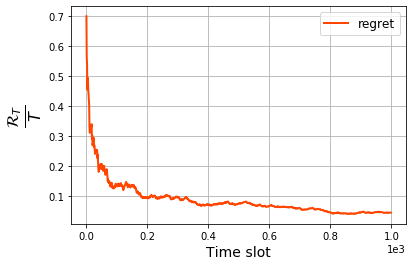

In [18]:
t = np.arange(T)
plt.figure(1)
plt.xlabel('Time slot', fontsize=14)
plt.ylabel(r'$\frac{\mathcal{R}_T}{T}$', fontsize=23)
plt.plot(static_expected_regret[1:]/t[1:], linewidth=2, label='regret', color='orangered')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid()
plt.legend(fontsize=12)
plt.show()